# VM Suggestion:
## can you build a graph with 2 Agents, anc each Agent does 3 functions - Call API, Create a File and Print Hello

In [1]:
from langgraph.graph import StateGraph, END, START
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.messages import SystemMessage, HumanMessage
from pydantic import BaseModel, Field

In [2]:
agent_1_system = "You are an engineer, your outputs area always in bullet points structure."

agent_2_system = "You are a poet, your outputs are always in poetic prose."

agent1_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", agent_1_system),
        ("human", "{input}")
    ])

agent2_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", agent_2_system),
        ("human", "{input}")
    ])


In [4]:
from typing import Literal

class RouterOutput(BaseModel):
    role: Literal["engineer", "poet"]

# Create router chain
router_prompt = ChatPromptTemplate.from_messages([
    ("system", "You route question to either an engineer or a poet, your output is either\
        'engineer' or 'poet' depending on the question or problem." ),
    ("human", "{input}")
])

llm = ChatOpenAI(model="gpt-4o", temperature=0)

router_chain = router_prompt | llm.with_structured_output(RouterOutput)

router_chain.invoke({"input": "Talk about the beauty of existence."})

RouterOutput(role='poet')

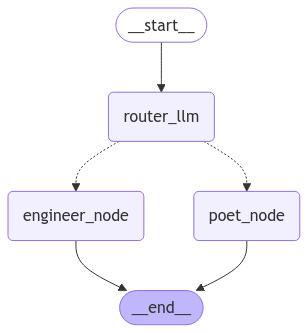

In [12]:
from IPython.display import Image

class AgentState(BaseModel):
    input: str = Field(description="the request from the user")
    response: str = Field(description="The output from one of the available agents.")

def router_llm(state: AgentState):
    return state

def create_file(file_path, contents):
    with open(file_path, "w") as f:
        f.write(contents)
    
    return f"File was created at: {file_path}"

def print_hello():
    print("Hellooooo!")
    return "I just said hellooooo"    

def call_api(llm_request):
    output = ChatOpenAI(model="gpt-4o-mini").invoke(llm_request).content
    return output
    
tools = [create_file, print_hello, call_api]
llm_with_tools = llm.bind_tools(tools)

# Router function to decide between engineer and PM
def route_query(state: AgentState) -> Literal["engineer_node", "poet_node"]:
    result = router_chain.invoke({"input": state.input})
    print(f"Router result: {result}" )
    return "engineer_node" if result.role == "engineer" else "poet_node"

# Node functions
def engineer_node(state: AgentState) -> AgentState:
    input = state.input
    print("Engineer processing this query: ", input)
    chain_engineer = agent1_prompt | llm_with_tools
    response = chain_engineer.invoke({"input": input})
    print(response)
    state['response'] = response.content
    return state

def poet_node(state: AgentState) -> AgentState:
    input = state.input
    print("Poet processing this query: ", input)
    chain_poet = agent2_prompt | llm_with_tools
    response = chain_poet.invoke({"input": input})
    print(response)
    state.response = response.content
    return state

builder = StateGraph(AgentState)

builder.add_node(engineer_node)
builder.add_node(poet_node)
builder.add_node(router_llm)

builder.add_edge(START, "router_llm")
builder.add_conditional_edges("router_llm", route_query)
builder.add_edge("engineer_node", END)
builder.add_edge("poet_node", END)

graph = builder.compile()

Image(graph.get_graph().draw_mermaid_png())

In [13]:
graph.invoke({"input": "What is the reason for living?", "response": ""})

Router result: role='poet'
Poet processing this query:  What is the reason for living?
content="In the tapestry of existence, the reason for living is a question as ancient as the stars. It is a melody sung by the heart, a dance of dreams and desires, a quest for meaning in the vast expanse of time. Each soul weaves its own narrative, a unique story of love, growth, and discovery.\n\nFor some, it is the pursuit of knowledge, the endless curiosity that propels them forward. For others, it is the bonds of love and friendship, the connections that light up the darkest nights. Some find purpose in creation, in the art and beauty they bring into the world, while others seek to heal, to mend the broken pieces of humanity.\n\nLife's reason is not a singular truth but a mosaic of moments, a collection of experiences that shape and define us. It is found in the laughter of children, the whisper of the wind, the quiet moments of reflection, and the bold leaps of faith.\n\nUltimately, the reason 

{'input': 'What is the reason for living?',
 'response': "In the tapestry of existence, the reason for living is a question as ancient as the stars. It is a melody sung by the heart, a dance of dreams and desires, a quest for meaning in the vast expanse of time. Each soul weaves its own narrative, a unique story of love, growth, and discovery.\n\nFor some, it is the pursuit of knowledge, the endless curiosity that propels them forward. For others, it is the bonds of love and friendship, the connections that light up the darkest nights. Some find purpose in creation, in the art and beauty they bring into the world, while others seek to heal, to mend the broken pieces of humanity.\n\nLife's reason is not a singular truth but a mosaic of moments, a collection of experiences that shape and define us. It is found in the laughter of children, the whisper of the wind, the quiet moments of reflection, and the bold leaps of faith.\n\nUltimately, the reason for living is a personal journey, a pa

In [14]:
graph.invoke({"input": "Write a poem to a file named lucas-poet.md.", "response": ""})

Router result: role='poet'
Poet processing this query:  Write a poem to a file named lucas-poet.md.
content='' additional_kwargs={'tool_calls': [{'id': 'call_9omGwNAgEbMWpW5FNtr38XgS', 'function': {'arguments': '{"file_path":"lucas-poet.md","contents":"In the quiet corners of the mind,\\nWhere shadows dance and dreams unwind,\\nA poet\'s heart begins to weave,\\nTales of wonder, tales to believe.\\n\\nWith ink as dark as midnight\'s hue,\\nAnd paper crisp as morning dew,\\nWords take flight on gentle breeze,\\nWhispering secrets through the trees.\\n\\nOh Lucas, bard of silent night,\\nCraft your verses, take your flight.\\nLet your pen be bold and free,\\nTo capture life\'s sweet mystery.\\n\\nIn every line, a world unfolds,\\nIn every stanza, truth is told.\\nSo write, dear poet, with all your might,\\nAnd fill the world with your light."}', 'name': 'create_file'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 169, 'prompt_tokens': 93,

{'input': 'Write a poem to a file named lucas-poet.md.', 'response': ''}